In [1]:
from helpers import PassSampler
import torch
import time
import matplotlib.pyplot as plt

# from botorch.acquisition.objective import ConstrainedMCObjective
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch import fit_gpytorch_model
from botorch.sampling.samplers import SobolQMCNormalSampler

from utils import (
    generate_initial_data,
    initialize_model,
    parse,
    optimize_acqf_and_get_observation,
    update_random_observations,
    get_problem,
    assess_coverage,
)
from helpers import qConformalExpectedImprovement, qConformalNoisyExpectedImprovement
from botorch.models.transforms import Standardize, Normalize

In [2]:
!nvidia-smi

Tue Apr 19 17:09:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    On   | 00000000:1A:00.0 Off |                  N/A |
| 40%   27C    P8    10W / 280W |   2826MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN RTX    On   | 00000000:1B:00.0 Off |                  N/A |
| 40%   

In [3]:
dtype = torch.double# if dtype == "double" else torch.float
device = torch.device("cuda:1")

torch.random.manual_seed(0)

bb_fn = get_problem("levy", 5)
bb_fn = bb_fn.to(device, dtype)
# bounds = torch.stack((torch.zeros(bb_fn.dim), torch.ones(bb_fn.dim)).to(device, dtype)
bounds = torch.zeros_like(bb_fn.bounds)
bounds[1] += 1.

In [4]:
(
        train_x_ei,
        train_obj_ei,
        best_observed_value_ei,
    ) = generate_initial_data(
        30, bb_fn, 0.1, device, dtype
    )

torch.Size([30, 5]) torch.Size([30, 1])


In [5]:
train_yvar = torch.tensor(0.1 ** 2, device=device, dtype=dtype)

In [6]:
mll_and_model = initialize_model(
            train_x_ei, train_obj_ei, train_yvar,
            method="exact", alpha=0.05, tgt_grid_res=64,
        )

In [7]:
(
        val_x,
        val_obj,
        _,
    ) = generate_initial_data(
        100, bb_fn, 0.1, device, dtype
    )

torch.Size([100, 5]) torch.Size([100, 1])


In [8]:
fit_gpytorch_model(mll_and_model[0]);

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [9]:
%pdb

Automatic pdb calling has been turned ON


In [10]:
cred_bounds, conf_bounds = assess_coverage(mll_and_model[1], val_x, val_obj, return_bounds=True)

0


/home/wesley_m/gpytorch/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1650352300814/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1675.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


In [11]:
trans_val_y = mll_and_model[2](val_obj)[0].cpu()

Text(0.5, 1.0, 'Levy-5')

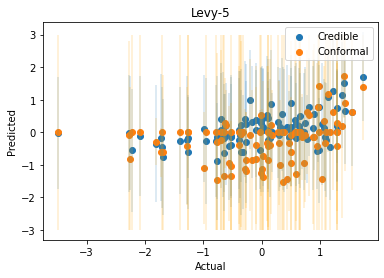

In [12]:
plt.vlines(trans_val_y, cred_bounds[0].cpu(), cred_bounds[1].cpu(), alpha = 0.2)
plt.scatter(trans_val_y, (cred_bounds[0] + cred_bounds[1]).cpu() / 2, label = "Credible")
plt.vlines(trans_val_y, conf_bounds[0].cpu(), conf_bounds[1].cpu(), color = "orange", alpha = 0.2)
plt.scatter(trans_val_y, (conf_bounds[0] + conf_bounds[1]).cpu() / 2, label = "Conformal")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Levy-5")

Text(0.5, 1.0, 'Width of Equivalent Intervals')

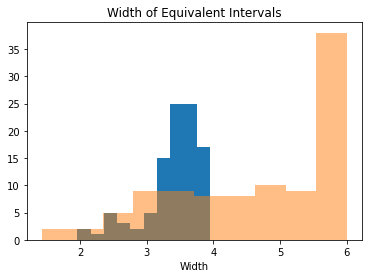

In [16]:
plt.hist((cred_bounds[1] - cred_bounds[0]).cpu().numpy())
plt.hist((conf_bounds[1] - conf_bounds[0]).cpu().numpy(), alpha = 0.5)
plt.xlabel("Width")
plt.title("Width of Equivalent Intervals")

## ignore below

In [7]:
xx, yy = torch.meshgrid(torch.linspace(0, 1, 40), torch.linspace(0, 1, 40))
test_x = torch.stack((xx.reshape(-1), yy.reshape(-1))).t().to(device, dtype)

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/functional.py:476: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1650352300814/work/aten/src/ATen/native/TensorShape.cpp:2349.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
mll, model, trans = mll_and_model

In [9]:
inputs, objective = train_x_ei, train_obj_ei

In [10]:
trans.eval()
t_objective = trans(objective)[0]

In [11]:
acqf = qConformalExpectedImprovement(
    model=model,
    best_f=(t_objective).max(),
    sampler=PassSampler(64),
)
acqf.objective._verify_output_shape = False

In [12]:
with torch.no_grad():
    model.conformal()
    conformalei = acqf(test_x.unsqueeze(-2))
    

/home/wesley_m/gpytorch/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1650352300814/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1675.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


In [13]:
model.standard()
acqf = qExpectedImprovement(
    model=model,
    best_f=(t_objective).max(),
)

In [14]:
with torch.no_grad():
    stdei = acqf(test_x.unsqueeze(-2))

Text(0.5, 1.0, 'Standard EI')

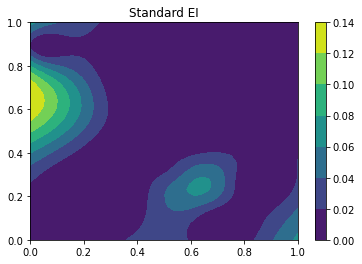

In [15]:
f = plt.contourf(xx, yy, stdei.cpu().reshape(40,40))
plt.colorbar(f)
plt.title("Standard EI")

Text(0.5, 1.0, 'Conformal EI')

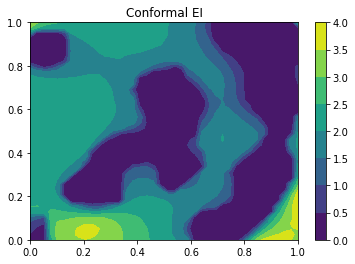

In [16]:
f = plt.contourf(xx, yy, conformalei.cpu().reshape(40,40))
plt.colorbar(f)
plt.title("Conformal EI")

In [17]:
n_batch = 30
batch_size = 1
num_init = 10
noise_se = 0.1
method = "exact"
alpha = 0.05
tgt_grid_res = 64
mc_samples = 64

torch.Size([200, 2]) torch.Size([200, 1])


/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.85999995470047, 0.9049999713897705) ei
torch.Size([10, 2]) torch.Size([10]) shapes


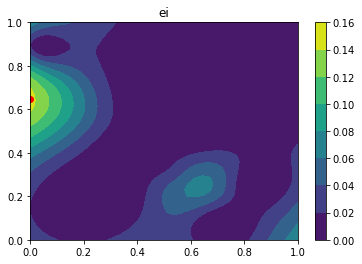

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.85999995470047, 0.9049999713897705) cei
torch.Size([10, 2]) torch.Size([10]) shapes


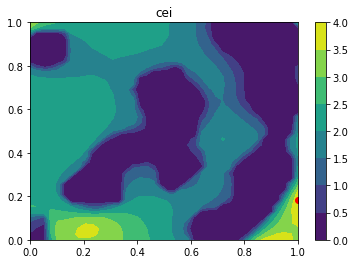

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7799999713897705, 0.8399999737739563) ei
torch.Size([11, 2]) torch.Size([11]) shapes


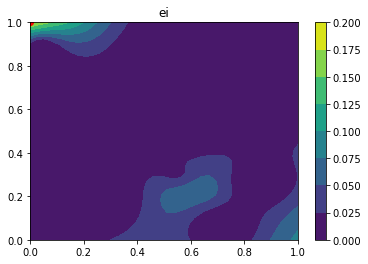

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.8100000023841858, 0.9149999618530273) cei
torch.Size([11, 2]) torch.Size([11]) shapes


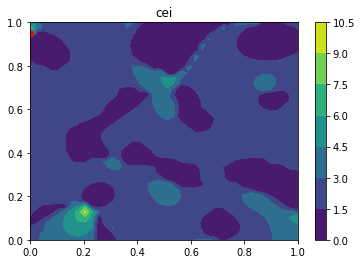

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7849999666213989, 0.9049999713897705) ei
torch.Size([12, 2]) torch.Size([12]) shapes


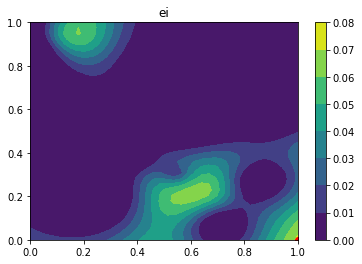

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7649999856948853, 0.8549999594688416) cei
torch.Size([12, 2]) torch.Size([12]) shapes


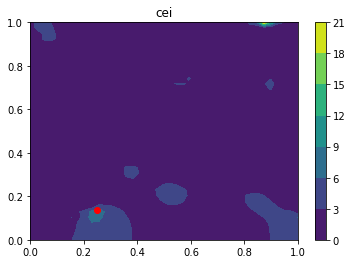

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.699999988079071, 0.6949999928474426) ei
torch.Size([13, 2]) torch.Size([13]) shapes


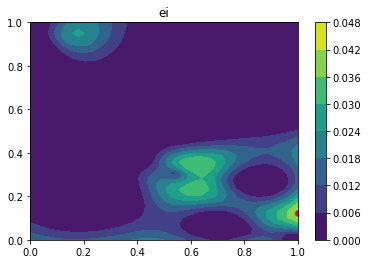

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7249999642372131, 0.949999988079071) cei
torch.Size([13, 2]) torch.Size([13]) shapes


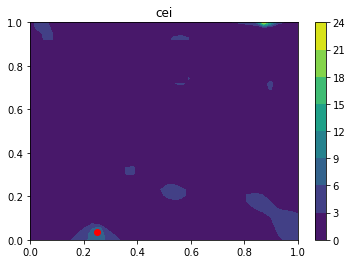

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7549999952316284, 0.6899999976158142) ei
torch.Size([14, 2]) torch.Size([14]) shapes


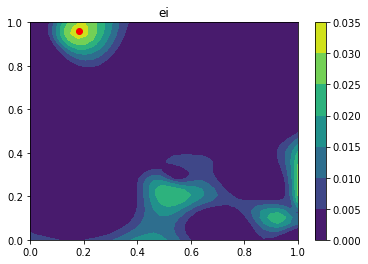

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7099999785423279, 0.9199999570846558) cei
torch.Size([14, 2]) torch.Size([14]) shapes


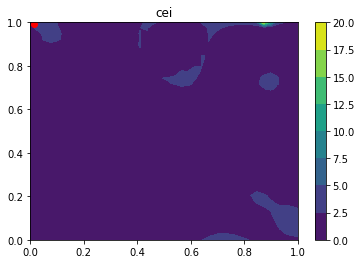

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.6399999856948853, 0.6349999904632568) ei
torch.Size([15, 2]) torch.Size([15]) shapes


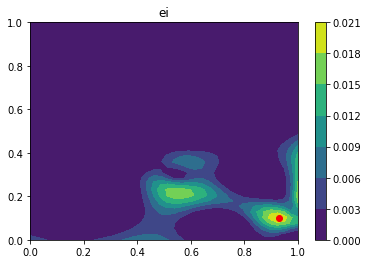

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9099999666213989, 0.949999988079071) cei
torch.Size([15, 2]) torch.Size([15]) shapes


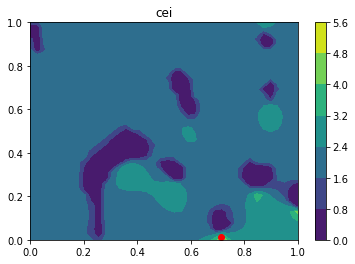

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.5849999785423279, 0.6499999761581421) ei
torch.Size([16, 2]) torch.Size([16]) shapes


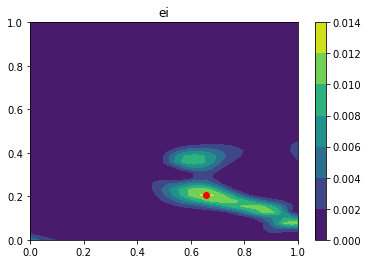

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9099999666213989, 0.9449999928474426) cei
torch.Size([16, 2]) torch.Size([16]) shapes


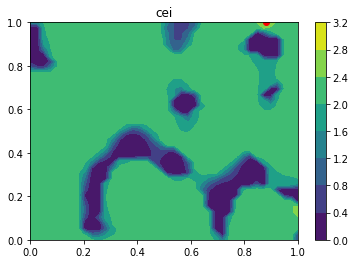

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.5299999713897705, 0.6800000071525574) ei
torch.Size([17, 2]) torch.Size([17]) shapes


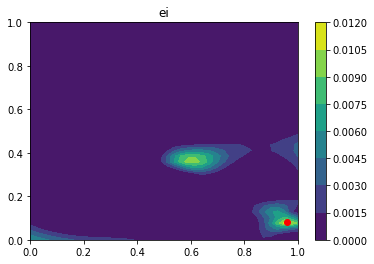

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9300000071525574, 0.9699999690055847) cei
torch.Size([17, 2]) torch.Size([17]) shapes


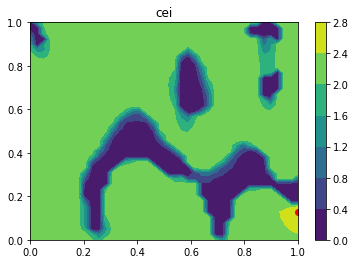

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.5099999904632568, 0.6599999666213989) ei
torch.Size([18, 2]) torch.Size([18]) shapes


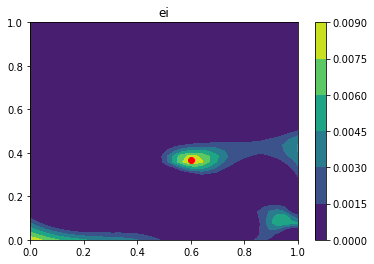

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9300000071525574, 0.9749999642372131) cei
torch.Size([18, 2]) torch.Size([18]) shapes


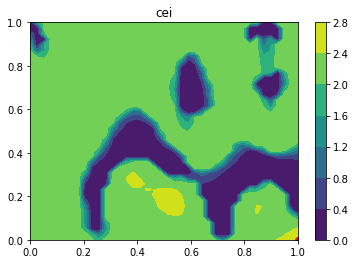

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7199999690055847, 0.7299999594688416) ei
torch.Size([19, 2]) torch.Size([19]) shapes


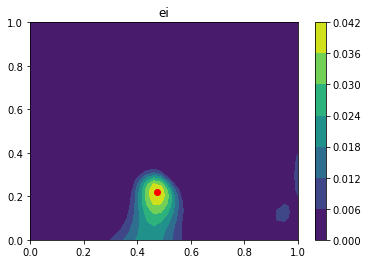

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9300000071525574, 0.9749999642372131) cei
torch.Size([19, 2]) torch.Size([19]) shapes


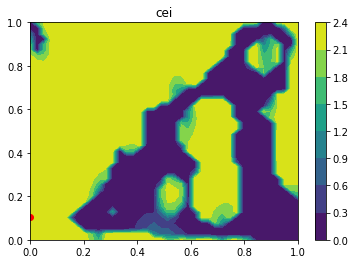

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.6549999713897705, 0.6699999570846558) ei
torch.Size([20, 2]) torch.Size([20]) shapes


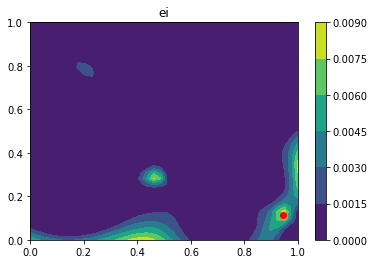

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9399999976158142, 0.9549999833106995) cei
torch.Size([20, 2]) torch.Size([20]) shapes


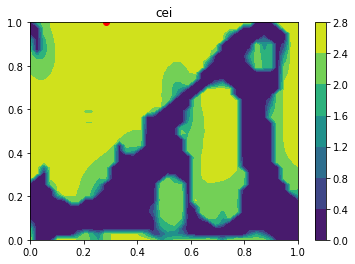

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.6549999713897705, 0.6499999761581421) ei
torch.Size([21, 2]) torch.Size([21]) shapes


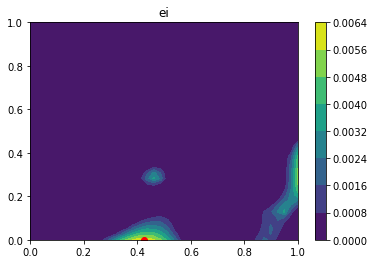

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9399999976158142, 0.949999988079071) cei
torch.Size([21, 2]) torch.Size([21]) shapes


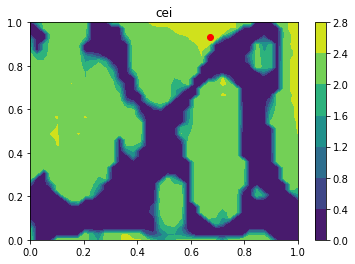

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.6349999904632568, 0.6399999856948853) ei
torch.Size([22, 2]) torch.Size([22]) shapes


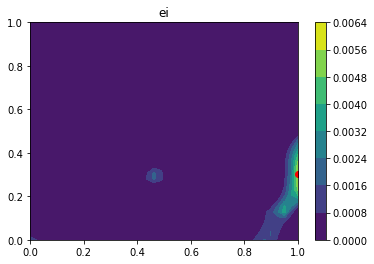

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9449999928474426, 0.9549999833106995) cei
torch.Size([22, 2]) torch.Size([22]) shapes


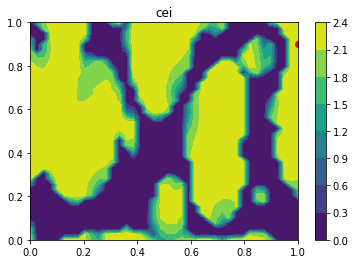

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7299999594688416, 0.6850000023841858) ei
torch.Size([23, 2]) torch.Size([23]) shapes


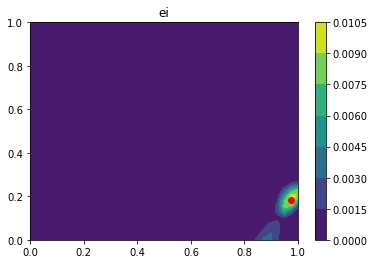

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9399999976158142, 0.9599999785423279) cei
torch.Size([23, 2]) torch.Size([23]) shapes


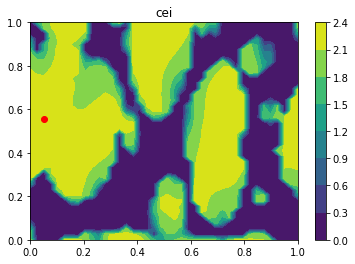

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7649999856948853, 0.7199999690055847) ei
torch.Size([24, 2]) torch.Size([24]) shapes


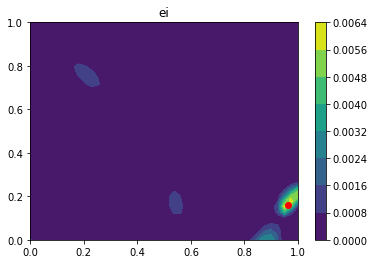

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9749999642372131, 0.9249999523162842) cei
torch.Size([24, 2]) torch.Size([24]) shapes


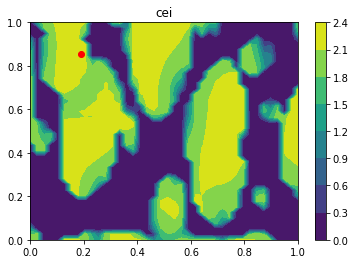

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7649999856948853, 0.7149999737739563) ei
torch.Size([25, 2]) torch.Size([25]) shapes


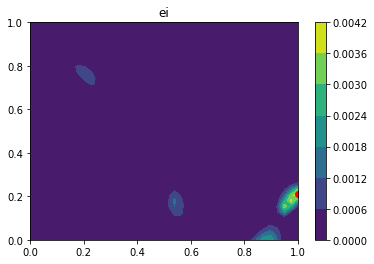

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9699999690055847, 0.9049999713897705) cei
torch.Size([25, 2]) torch.Size([25]) shapes


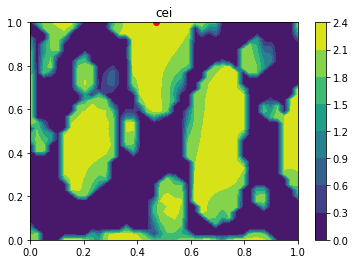

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7799999713897705, 0.7249999642372131) ei
torch.Size([26, 2]) torch.Size([26]) shapes


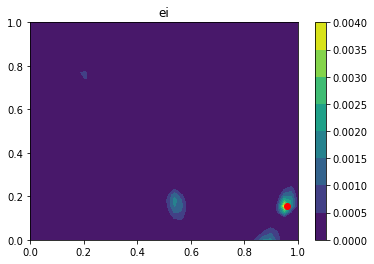

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9699999690055847, 0.9049999713897705) cei
torch.Size([26, 2]) torch.Size([26]) shapes


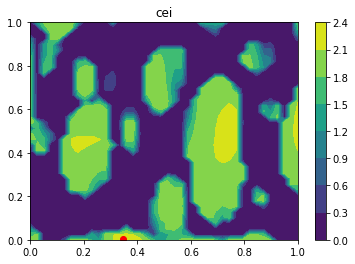

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7799999713897705, 0.7149999737739563) ei
torch.Size([27, 2]) torch.Size([27]) shapes


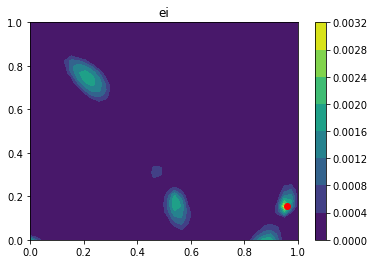

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.98499995470047, 0.9249999523162842) cei
torch.Size([27, 2]) torch.Size([27]) shapes


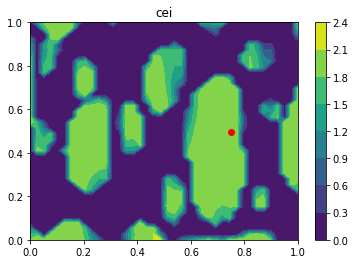

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7799999713897705, 0.7249999642372131) ei
torch.Size([28, 2]) torch.Size([28]) shapes


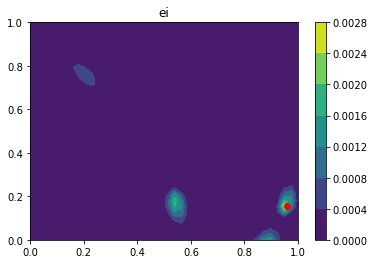

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.98499995470047, 0.9199999570846558) cei
torch.Size([28, 2]) torch.Size([28]) shapes


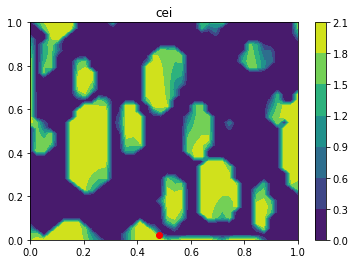

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.7799999713897705, 0.5450000166893005) ei
torch.Size([29, 2]) torch.Size([29]) shapes


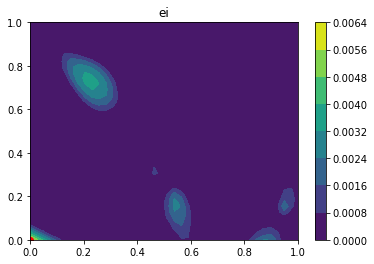

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9899999499320984, 0.8999999761581421) cei
torch.Size([29, 2]) torch.Size([29]) shapes


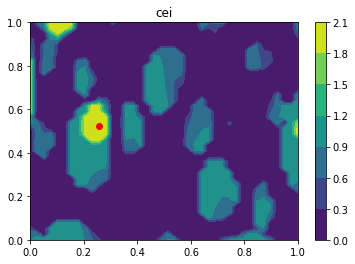

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9199999570846558, 0.7599999904632568) ei
torch.Size([30, 2]) torch.Size([30]) shapes


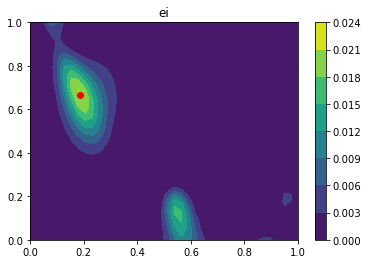

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9950000047683716, 0.8949999809265137) cei
torch.Size([30, 2]) torch.Size([30]) shapes


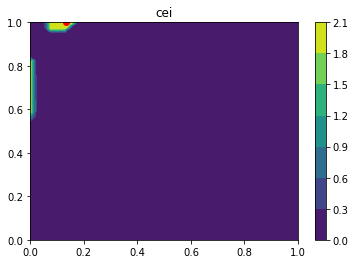

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9249999523162842, 0.8149999976158142) ei
torch.Size([31, 2]) torch.Size([31]) shapes


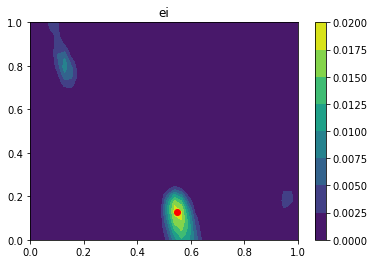

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9950000047683716, 0.8999999761581421) cei
torch.Size([31, 2]) torch.Size([31]) shapes


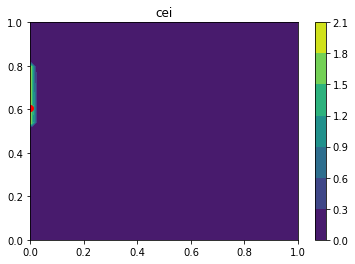

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9199999570846558, 0.8050000071525574) ei
torch.Size([32, 2]) torch.Size([32]) shapes


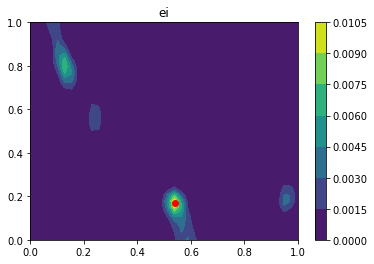

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9899999499320984, 0.9049999713897705) cei
torch.Size([32, 2]) torch.Size([32]) shapes


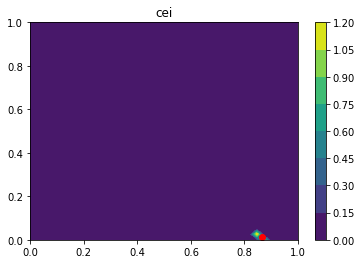

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9149999618530273, 0.8100000023841858) ei
torch.Size([33, 2]) torch.Size([33]) shapes


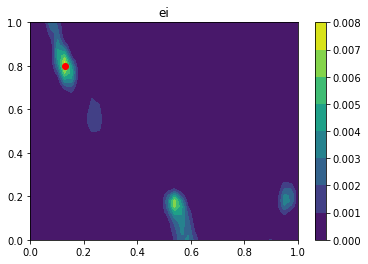

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.98499995470047, 0.8849999904632568) cei
torch.Size([33, 2]) torch.Size([33]) shapes


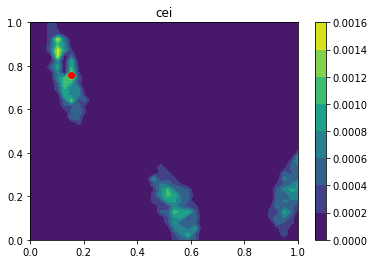

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9249999523162842, 0.8050000071525574) ei
torch.Size([34, 2]) torch.Size([34]) shapes


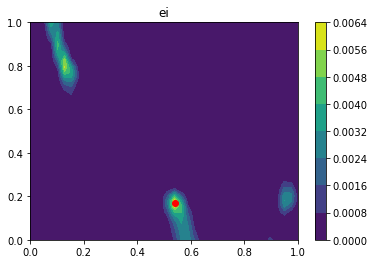

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9950000047683716, 0.9049999713897705) cei
torch.Size([34, 2]) torch.Size([34]) shapes


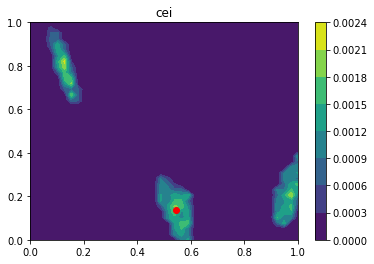

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9199999570846558, 0.8149999976158142) ei
torch.Size([35, 2]) torch.Size([35]) shapes


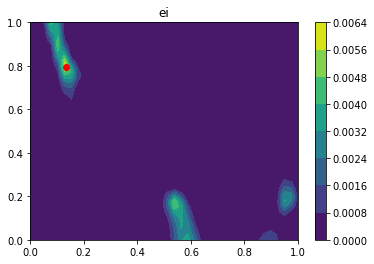

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9950000047683716, 0.8899999856948853) cei
torch.Size([35, 2]) torch.Size([35]) shapes


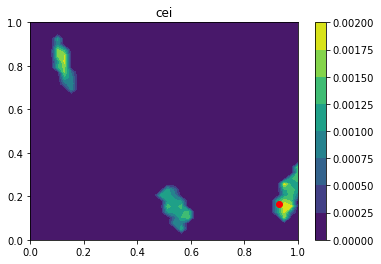

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9199999570846558, 0.8199999928474426) ei
torch.Size([36, 2]) torch.Size([36]) shapes


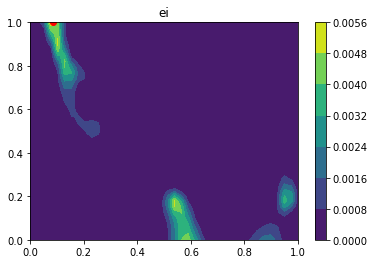

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9950000047683716, 0.8949999809265137) cei
torch.Size([36, 2]) torch.Size([36]) shapes


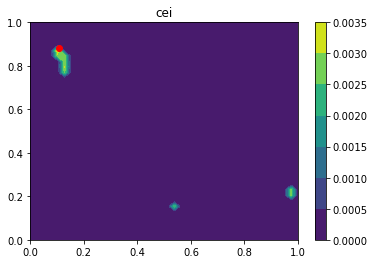

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9350000023841858, 0.8349999785423279) ei
torch.Size([37, 2]) torch.Size([37]) shapes


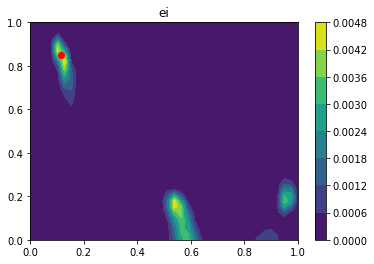

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9950000047683716, 0.8849999904632568) cei
torch.Size([37, 2]) torch.Size([37]) shapes


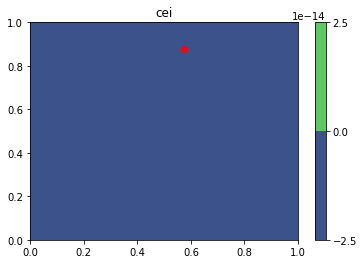

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9300000071525574, 0.8399999737739563) ei
torch.Size([38, 2]) torch.Size([38]) shapes


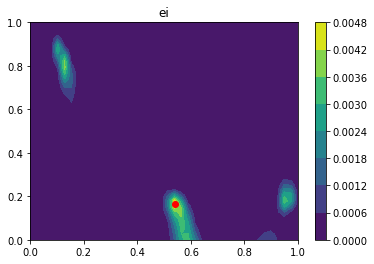

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9950000047683716, 0.875) cei
torch.Size([38, 2]) torch.Size([38]) shapes


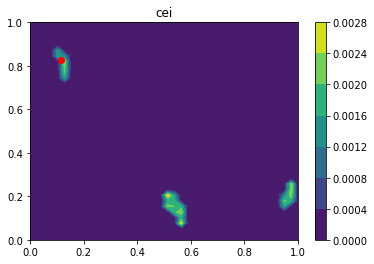

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9300000071525574, 0.8299999833106995) ei
torch.Size([39, 2]) torch.Size([39]) shapes


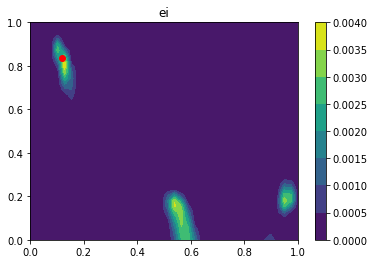

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


(0.9950000047683716, 0.8799999952316284) cei
torch.Size([39, 2]) torch.Size([39]) shapes


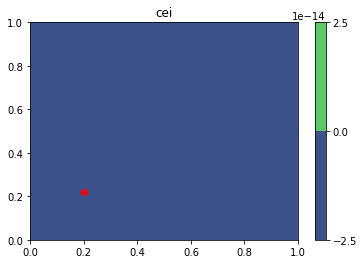

In [18]:
keys = ["ei", "cei"]
best_observed = {k: [] for k in keys}
coverage = {k: [] for k in keys}

# call helper functions to generate initial training data and initialize model
# (
#     train_x_ei,
#     train_obj_ei,
#     best_observed_value_ei,
# ) = generate_initial_data(
#     num_init, bb_fn, noise_se, device, dtype
# )
heldout_x, heldout_obj, _ = generate_initial_data(20 * num_init, bb_fn, noise_se, device, dtype)

mll_model_dict = {}
data_dict = {}
for k in keys:
    mll_and_model = initialize_model(
        train_x_ei, train_obj_ei, train_yvar,
        method=method, alpha=alpha, tgt_grid_res=tgt_grid_res,
    )
    mll_model_dict[k] = (mll_and_model)
    best_observed[k].append(best_observed_value_ei)
    data_dict[k] = (train_x_ei, train_obj_ei)

optimize_acqf_kwargs = {
    "bounds": bounds,
    "BATCH_SIZE": batch_size,
    "fn": bb_fn,
    "noise_se": noise_se,
}

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, n_batch + 1):
    t0 = time.time()
    for k in keys:
        torch.cuda.empty_cache()
        
        if k == "rnd":
            # update random
            best_observed[k] = update_random_observations(batch_size, best_observed[k], bb_fn.bounds, bb_fn, dim=bounds.shape[1])
            continue

        # fit the model
        mll, model, trans = mll_model_dict[k]
        inputs, objective = data_dict[k]
        trans.eval()
        t_objective = trans(objective)[0]
        # model.requires_grad_(True)
        fit_gpytorch_model(mll)
        # model.requires_grad_(False)
#         print(list(model.named_parameters()))
        # now assess coverage on the heldout set
        # TODO: update the heldout sets
        coverage[k].append(assess_coverage(model, heldout_x, trans(heldout_obj)[0], alpha))
        print(coverage[k][-1], k)

        # now prepare the acquisition
        qmc_sampler = SobolQMCNormalSampler(num_samples=mc_samples)
        if k == "ei":
            acqf = qExpectedImprovement(
                model=model,
                best_f=(t_objective).max(),
               sampler=qmc_sampler,
            )
        elif k == "nei":
            acqf = qNoisyExpectedImprovement(
                model=model,
                X_baseline=inputs,
                sampler=qmc_sampler,
            )
        elif k == "kg":
            acqf = qKnowledgeGradient(
                model=model,
                current_value=t_objective.max(),
                num_fantasies=None,
                sampler=qmc_sampler,
            )
        elif k == "cei":
            model.conformal()
            acqf = qConformalExpectedImprovement(
                model=model,
                best_f=(t_objective).max(),
                sampler=PassSampler(mc_samples),
            )
            acqf.objective._verify_output_shape = False
        elif k == "cnei":
            model.conformal()
            acqf = qConformalNoisyExpectedImprovement(
                model=model,
                X_baseline=inputs,
                sampler=PassSampler(mc_samples),
                cache_root=False,
            )
            acqf.objective._verify_output_shape = False
        
        print(model.train_inputs[0].shape, model.train_targets.shape, 'shapes')
        # optimize acquisition
        new_x, new_obj = optimize_acqf_and_get_observation(
            acqf, **optimize_acqf_kwargs
        )
        new_x = new_x.detach()
    
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            output = acqf(test_x.unsqueeze(-2)).cpu()
            plt.figure()
            f = plt.contourf(xx, yy, output.reshape(40, 40))
            plt.colorbar(f)
        
        # display new pt
        plt.scatter(new_x[0,0].cpu(), new_x[0,1].cpu(), color = "red")
        plt.title(k)
        plt.show()
            
        inputs = torch.cat([inputs, new_x])
        objective = torch.cat([objective, new_obj])

        best_observed[k].append(objective.max().item())
        # prepare new model
        mll, model, trans = initialize_model(
            inputs,
            objective,
            method=method,
        )
        mll_model_dict[k] = (mll, model, trans)
        data_dict[k] = inputs, objective

    t1 = time.time()


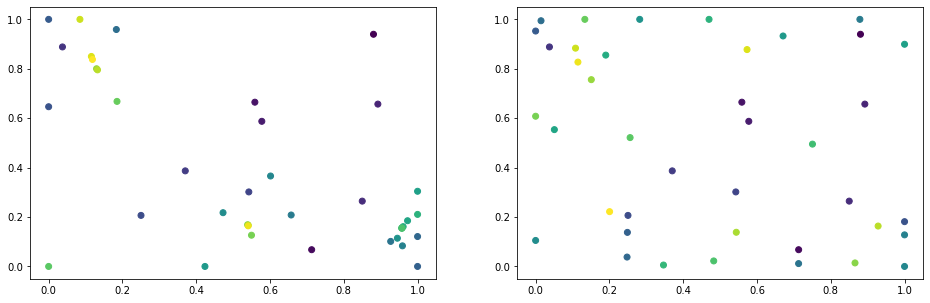

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax[0].scatter(*data_dict["ei"][0].t().cpu(), c=torch.arange(40))
ax[1].scatter(*data_dict["cei"][0].t().cpu(),c=torch.arange(40))

(-20.0, 0.0)

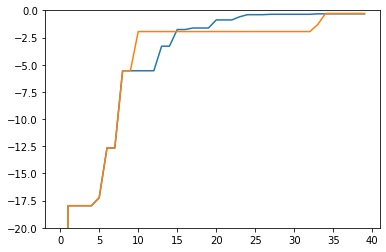

In [30]:
plt.plot(data_dict["ei"][1].cpu().cummax(0)[0])
plt.plot(data_dict["cei"][1].cpu().cummax(0)[0])
plt.ylim((-20, 0))